In [2]:
import cv2
import numpy as np

img = cv2.imread("sources/emblema.jpg")
#img = cv2.imread("sources/Geeks.png")
#img = cv2.imread("sources/caras.jpg")

print(len(img[0]))

print(img.shape)

img2 = cv2.resize(img,(900, 545), interpolation=cv2.INTER_BITS)

gauss = cv2.GaussianBlur(img2,(5,5),3)


hpf = img2 - gauss



cv2.imshow("img", img)
cv2.imshow("img2", img2)
cv2.imshow("hpf", hpf)
cv2.imshow("gaus", gauss)
cv2.waitKey()
cv2.destroyAllWindows()



1920
(1081, 1920, 3)


# Conceptualizing Haar cascades

Cuando hablamos de clasificar objetos y rastrear su ubicación, ¿qué es exactamente lo que esperamos identificar? ¿Qué constituye una parte reconocible de un objeto?

Las imágenes fotográficas, incluso desde una cámara web, pueden contener muchos detalles para nuestro placer visual (humano). Sin embargo, el detalle de la imagen tiende a ser inestable con respecto a las variaciones en la iluminación, el ángulo de visión, la distancia de visión, el movimiento de la cámara y el ruido digital. Además, incluso las diferencias reales en los detalles físicos podrían no interesarnos para la clasificación. A Joseph Howse, uno de los autores de este libro, se le enseñó en la escuela que no hay dos copos de nieve iguales bajo un microscopio. Afortunadamente, cuando era un niño canadiense, ya había aprendido a reconocer copos de nieve sin un microscopio, ya que las similitudes son más obvias a granel.

Por lo tanto, tener algunos medios para abstraer los detalles de la imagen es útil para producir resultados estables de clasificación y seguimiento. Las abstracciones se llaman características, que se dice que se extraen de los datos de la imagen. Debe haber muchas menos características que píxeles, aunque cualquier píxel puede influir en múltiples características. Un conjunto de entidades se representa como un vector (conceptualmente, un conjunto de coordenadas en un espacio multidimensional), y el nivel de similitud entre dos imágenes se puede evaluar en función de alguna medida de la distancia entre los vectores de características correspondientes de las imágenes.

Más adelante, en el Capítulo 6, Recuperación de imágenes y búsqueda mediante descriptores de imágenes, exploraremos varios tipos de características, así como formas avanzadas de describir y hacer coincidir conjuntos de entidades.

Las características similares a Haar son un tipo de característica que a menudo se aplica a la detección de rostros en tiempo real. Se utilizaron por primera vez para este propósito en el artículo Robust Real-Time Face Detection, de Paul Viola y Michael Jones (International Journal of Computer Vision 57 (2), 137-154, Kluwer Academic Publishers, 2001). Una versión electrónica de este documento está disponible en http://comp3204.ecs.soton.ac.uk/cw/viola04ijcv.pdf.

Cada característica similar a Haar describe el patrón de contraste entre las regiones de imagen adyacentes. Por ejemplo, las aristas, los vértices y las líneas finas generan cada uno un tipo de entidad. Algunas características son distintivas en el sentido de que típicamente ocurren en una cierta clase de objeto (como una cara) pero no en otros objetos. Estas características distintivas se pueden organizar en una jerarquía, llamada cascada, en la que las capas más altas contienen características de mayor distinción, lo que permite a un clasificador rechazar rápidamente los sujetos que carecen de estas características. Si un sujeto es una buena combinación para las características de la capa superior, entonces el clasificador también considera las características de la capa inferior para eliminar más falsos positivos.

Para cualquier sujeto dado, las características pueden variar dependiendo de la escala de la imagen y el tamaño del vecindario (la región de píxeles cercanos) en el que se evalúa el contraste. El tamaño del vecindario se llama tamaño de ventana. Para hacer que un clasificador en cascada de Haar sea invariante de escala o, en otras palabras, robusto a los cambios de escala, el tamaño de la ventana se mantiene constante, pero las imágenes se reescalan varias veces; Por lo tanto, en algún nivel de reescalado, el tamaño de un objeto (como una cara) puede coincidir con el tamaño de la ventana. Juntas, la imagen original y las imágenes reescaladas se denominan pirámide de imágenes, y cada nivel sucesivo en esta pirámide es una imagen reescalada más pequeña. OpenCV proporciona un clasificador invariante de escala que puede cargar una cascada de Haar desde un archivo XML en un formato determinado. Internamente, este clasificador convierte cualquier imagen dada en una pirámide de imágenes.

Las cascadas de Haar, tal como se implementan en OpenCV, no son robustas a los cambios en la rotación o la perspectiva. Por ejemplo, una cara al revés no se considera similar a una cara erguida y una cara vista de perfil no se considera similar a una cara vista desde el frente. Una implementación más compleja e intensiva en recursos podría mejorar la robustez de una cascada de Haar a la rotación al considerar múltiples transformaciones de imágenes, así como múltiples tamaños de ventana. Sin embargo, nos limitaremos a la implementación en OpenCV.


## Obtención de datos en cascada de Haar

La instalación de OpenCV 5 debe contener una subcarpeta llamada . La ruta a esta carpeta se almacena en una variable OpenCV denominada . `datacv2.data.haarcascades`

La carpeta contiene archivos XML que pueden ser cargados por una clase OpenCV llamada . Una instancia de esta clase interpreta un archivo XML determinado como una cascada de Haar, que proporciona un modelo de detección para un tipo de objeto, como una cara. Puede detectar este tipo de objeto en cualquier imagen. Como de costumbre, podríamos obtener una imagen fija de un archivo, o podríamos obtener una serie de fotogramas de un archivo de video o una cámara de video. `datacv2.CascadeClassifiercv2.CascadeClassifier`

Desde la carpeta, usaremos los siguientes archivos en cascada: `data`


`
haarcascade_frontalface_default.xml
haarcascade_eye.xml
`

Como sus nombres sugieren, estas cascadas son para detectar rostros y ojos. Requieren una visión frontal y vertical del sujeto. Los usaremos más adelante cuando construyamos un detector facial.

Si tienes curiosidad sobre cómo se generan estos archivos en cascada, puedes encontrar más información en el libro de Joseph Howse, OpenCV 4 for Secret Agents (Packt Publishing, 2019), específicamente en el Capítulo 3, Entrenando una alarma inteligente para reconocer al villano y su gato. Con mucha paciencia y una computadora razonablemente potente, puede hacer sus propias cascadas y entrenarlas para varios tipos de objetos.


## Uso de OpenCV para realizar la detección de rostros
con `cv2.CascadeClassifier`, hay poca diferencia  si realizamos la detección de rostros en una imagen fija o en una transmisión de video. El último es solo una versión secuencial del primero: la detección de rostros en un video es simplemente detección de rostros aplicada a cada cuadro. Naturalmente, con técnicas más avanzadas, sería posible rastrear una cara detectada continuamente a través de múltiples cuadros y determinar que la cara es la misma en cada cuadro. Sin embargo, es bueno saber que un enfoque secuencial básico también funciona.

Sigamos adelante y detectemos algunas caras.

### Realización de la detección de rostros en una imagen fija
La primera y más básica forma de realizar la detección de rostros es cargar una imagen y detectar rostros en ella. Para que el resultado sea visualmente significativo, dibujaremos rectángulos alrededor de las caras en la imagen original. Recordando que el detector de rostros está diseñado para caras verticales y frontales, usaremos una imagen de una fila de personas, específicamente leñadores, de pie hombro con hombro y mirando hacia el fotógrafo o espectador.

Sigamos adelante y creemos el siguiente script básico para realizar la detección de rostros:

In [3]:
import cv2
cara_cascadas = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_frontalface_default.xml')
print(cv2.data.haarcascades)

img = cv2.imread("sources/caras.jpg")
cv2.imshow('caras detectadas!', img)
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2.imshow('caras detectadas!', gris)

caras = cara_cascadas.detectMultiScale(gris, 1.08, 3)

print(caras)

for (x, y, w, h) in caras:
    img2 = cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 255, 0), 2)
    
cv2.namedWindow('caras detectadas!')
cv2.imshow('caras detectadas!', img2)
cv2.imwrite('sources/caras detectadas.png', img2)


cv2.waitKey(0)
cv2.destroyAllWindows()

C:\Users\JONATHAN GONZALEZ\AppData\Roaming\Python\Python39\site-packages\cv2\data\
[[391 154  93  93]]


Repasemos el código anterior en pequeños pasos. Primero, usamos la importación obligatoria `cv2` que encontrará en cada guión de este libro. Luego, declaramos una variable `cara_cascadas`, que es un objeto `CascadeClassifier` que carga una cascada para la detección de rostros:

`cara_cascadas = cv2.CascadeClassifier(f'{cv2.data.haarcascades}haarcascade_frontalface_default.xml')`

Luego cargamos nuestro archivo de imagen `cv2.imread` y lo convertimos en escala de grises porque `CascadeClassifier`, como muchos de los clasificadores de OpenCV, espera imágenes en escala de grises. (Si intentamos usar una imagen en color, la convertiremos internamente a escala de grises de todos modos). El siguiente paso, `cara_cascadas.detectMultiScale` , es donde realizamos la detección de rostros real:

`
img = cv2.imread('../images/woodcutters.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.08, 5)
`

Los parámetros de `detectMultiScale` incluye `scaleFactor` y `minNeighbors`. El argumento `scaleFactor `, que debe ser mayor que 1.0, determina la relación de reducción de escala de la imagen en cada iteración del proceso de detección de rostros. Como discutimos anteriormente en la sección Conceptualización de las cascadas de Haar, esta reducción de escala está destinada a lograr la invariancia de escala al hacer coincidir varias caras con el tamaño de la ventana. El argumento `minNeighbors` es el número mínimo de detecciones superpuestas necesarias para conservar un resultado de detección. Normalmente, esperamos que una cara pueda detectarse en múltiples ventanas superpuestas, y un mayor número de detecciones superpuestas nos hace estar más seguros de que la cara detectada es realmente una cara.


El valor devuelto por la operación de detección es una lista de tuplas que representan los rectángulos faciales. La función `cv2.rectangle` de OpenCV nos permite dibujar rectángulos en las coordenadas especificadas. **X** y **Y** representan las coordenadas izquierda y superior, mientras que **W** y **H** representan el ancho y la altura del rectángulo de la cara. Dibujamos rectángulos cian alrededor de todas las caras que encontramos haciendo un bucle a través de la variable `faces`, asegurándonos de usar la imagen original para dibujar, no la versión gris:

`
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (255, 255255, 0), 2)
`

Por último, llamamos `cv2.imshow` para mostrar la imagen procesada resultante y llamamos `cv2.imwrite` para guardarla. Como de costumbre, para evitar que la ventana de imagen se cierre automáticamente, insertamos una llamada a `waitKey`, que regresa cuando el usuario presiona cualquier tecla:

`
cv2.imshow('Woodcutters Detected!', img)
cv2.imwrite('./woodcutters_detected.pngpng', img)
cv2.waitKey(0)
`

Y ahí vamos, tres miembros de la banda de leñadores han sido detectados en nuestra imagen, como se muestra en la siguiente captura de pantalla:

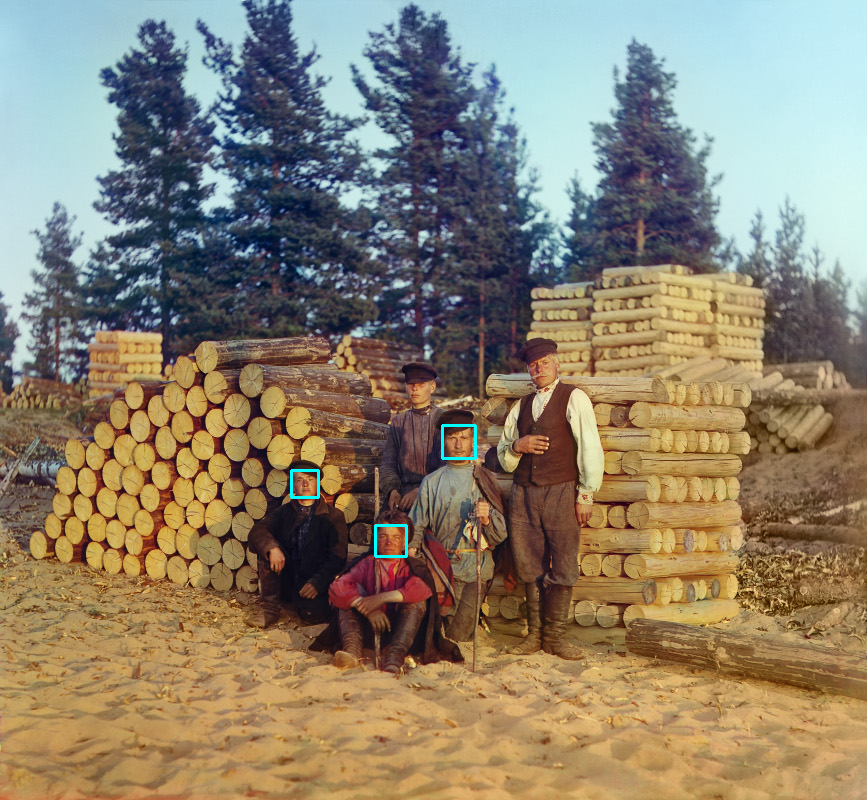


Aquí, no tenemos detecciones de falsos positivos; Los tres rectángulos realmente son caras de leñadores. Sin embargo, tenemos dos falsos negativos (leñadores cuyas caras no fueron detectadas). Intente ajustar los parámetros de `face_cascade.detectMultiScale` para ver cómo cambian los resultados. Luego, pasemos a un ejemplo más interactivo.


### Realizar la detección de rostros en un vídeo

Ahora entendemos cómo realizar la detección de rostros en una imagen fija. Como se mencionó anteriormente, podemos repetir el proceso de detección de rostros en cada fotograma de un video (ya sea una alimentación de cámara o un archivo de video pregrabado).

El siguiente script abrirá una alimentación de cámara, leerá un cuadro, examinará ese marco en busca de caras y buscará ojos dentro de las caras detectadas. Finalmente, dibujará rectángulos azules alrededor de las caras y rectángulos verdes alrededor de los ojos. Aquí está el guión en su totalidad:
